# Time evolution for single spins
-----------------------------------------------------------

In [26]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *

In this notebook, we explore the simulation of time evolution in single spin systems. For a quantum state $\left|\psi\right\rangle$, time evolution is governed by the Schrödinger equation,

$$i\hbar \frac{d}{dt}\left|\psi\right\rangle = \hat{H}\left|\psi\right\rangle.$$

For now, we'll assume a time-independent Hamiltonian. In particular, the relevant Hamiltonian for a spin in a constant magnetic field ${\bf B}$ is

$$\hat{H} = -\mu {\bf B}\cdot\hat{\bf S},$$

where $\lambda$ is some constant proportional to the magnetic moment of the spin and $\hat{\bf S} = \hat{S}^{x}\hat{\bf x} +  \hat{S}^{y}\hat{\bf y} + \hat{S}^{z}\hat{\bf z}$. 

As an example, let's suppose $\left|\psi(0)\right\rangle = \left|+\right\rangle$ and ${\bf B} = B_{0}\hat{y}$ for some constant $B_{0}$. Here we follow McIntyre's convention $\hat{S}^{z}|\pm\rangle = \frac{\hbar}{2}|\pm\rangle$ for spin states which are represented by qubits as $|+\rangle\rightarrow |0\rangle$, $|-\rangle \rightarrow |1\rangle$. Note Qiskit resources employ the alternate convention of defining superposition states $|\pm\rangle \equiv \frac{1}{\sqrt{2}}\left(|0\rangle \pm |1\rangle\right)$, which is <b>not</b> the case here. We take $|\pm\rangle$ to stand for the eigenstates of $\hat{S}^{z}$ and represent them by the computational basis kets, $\left\{|0\rangle, |1\rangle\right\}$. For this case, the Hamiltonian simplifies to

$$\hat{H} \rightarrow -\frac{\mu B_{0}\hbar}{2}\sigma^{y} \;\;\dot{=}\;\; -\hbar\omega\left(\begin{array}{cc} 0 & -i\\ i & 0\end{array}\right),$$

where $\omega \equiv \mu B_{0}$. The fundamental problem in quantum dynamics is to predict the probabilities of measurement outcomes or expectation values at some time $t$ given a Hamiltonian $\hat{H}$ and an initial state for the system, $\left|\psi(0)\right\rangle$. We first consider this simple example for which it is straightforward to solve the Schrödinger equation exactly. A formal integration gives

$$\left|\psi(t)\right\rangle = e^{-i\hat{H}t/\hbar}\left|\psi(0)\right\rangle$$,

where 

$$e^{-i\hat{H}t/\hbar} = e^{i\frac{\omega t}{2}\sigma^{y}}.$$

We can compute the exponential of a matrix by using the Taylor expansion of the exponential function as a definition.

$$e^{i\frac{\omega t}{2}\sigma^{y}} \equiv \hat{I} + i\frac{\omega t}{2}\sigma^{y} + \frac{\left(i\frac{\omega t}{2}\sigma^{y}\right)^{2}}{2!} + \frac{\left(i\frac{\omega t}{2}\sigma^{y}\right)^{3}}{3!} + \frac{\left(i\frac{\omega t}{2}\sigma^{y}\right)^{4}}{4!} + \cdots.$$

Using $(\sigma^{y})^{2} = \hat{I}$ and $i^{2} = -1$, one may group even and odd terms

$$e^{i\frac{\omega t}{2}\sigma^{y}} = \hat{I}\left[1 - \frac{(\omega t/2)^{2}}{2!} + \frac{(\omega t/2)^{4}}{4!} + \cdots\right] + i\sigma^{y}\left[\omega t - \frac{(\omega t/2)^{3}}{3!} + \frac{(\omega t/2)^{5}}{5!} + \cdots\right].$$

The series in brackets are cosine and sine Taylor expansions, respectively. Writing out $\hat{I}$ and $\sigma^{y}$ as explicit matrices, we get

$$e^{i\omega t/2\sigma^{y}} = \hat{I}\cos(\omega t/2) + i\sigma^{y}\sin(\omega t/2) \;\;\dot{=}\;\; \left(\begin{array}{cc} \cos(\omega t/2) & \sin(\omega t/2)\\ -\sin(\omega t/2) & \cos(\omega t/2)\end{array}\right)$$

Now recall the general $\hat{U}(\theta,\phi,\lambda)$ gate 

$$\hat{U}(\theta,\phi,\lambda) \;\;\dot{=} \left(\begin{array}{cc} \cos\frac{\theta}{2} & -e^{i\lambda}\sin\frac{\theta}{2} \\ e^{i\phi}\sin\frac{\theta}{2} & e^{i(\lambda + \phi)}\cos\frac{\theta}{2}\end{array}\right)$$

Then the time evolution is equivalent to the following $\hat{U}$ gate:

$$e^{-i\hat{H}t/\hbar} = \hat{U}(\omega t,\pi,\pi),$$

or $\left|\psi(t)\right\rangle = \hat{U}(\omega t,\pi,\pi)\left|+\right\rangle$. Exponentiating the Hamiltonian explicitly is rarely the most efficient way to solve for time dynamics analytically. See one of the [many](https://www.springer.com/gp/book/9780306447907) [excellent](https://www.pearson.com/us/higher-education/program/Mc-Intyre-Quantum-Mechanics/PGM64990.html) [textbooks](https://www.cambridge.org/highereducation/books/introduction-to-quantum-mechanics/990799CA07A83FC5312402AF6860311E#overview) on QM for the standard approach. But this approach does lend itself to an efficient quantum circuit design for calculating spin dynamics.

This is the case we will consider below.

The basic tasks accomplished by the circuit are:

1. Generate the initial quantum state $\left|\psi(0)\right\rangle$ through an appropriate unitary transformation of the default initialization $\left|+\right\rangle$.
2. Perform time evolution by applying the gate(s) corresponding to $e^{-i\hat{H}t/\hbar}$.
3. Measure desired observables by appropriate rotation followed by measurement in computational basis.

For our first example, we take $\left|\psi(0)\right\rangle = \left|+\right\rangle$, so no rotation is required before performing step 2. In this first example, let us compute the expectation values $\left\langle \hat{S}^{x}\right\rangle$, $\left\langle \hat{S}^{y}\right\rangle$, $\left\langle \hat{S}^{z}\right\rangle$. To be economical, we can actually embed three copies of the single-spin circuit which only differ in the final gates which select the appropriate spin component for measurement. 

In order to measure the system at a range of time values (say $0\leq \omega t\leq 2\pi$), we can define $\tau = \omega t$ as a parameter.

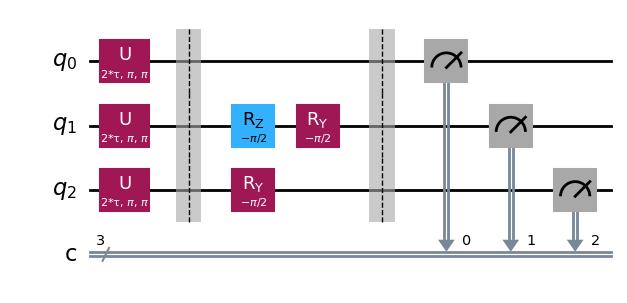

In [27]:
from qiskit.circuit import Parameter
tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc = QuantumCircuit(qr,cr) 

#no initial unitary transformation since |ψ(0)> = |+>

timecirc.u(2*tau,np.pi,np.pi,qr) #apply exp(-iHt/ħ)
timecirc.barrier(qr)
timecirc.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc.rz(-np.pi/2,1) 
timecirc.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc.barrier(qr)
#no rotation needed to measure <Sz>

timecirc.measure(qr,cr)
timecirc.draw('mpl')

Next, we define the range for $\tau$ and run on the simulator for some number of shots. This circuit, in which time is a parameter, provides us an opportunity to bundle parameters into the primitive unified bloc (PUB) as follows.

In [28]:
tau_range = np.linspace(0, 2*np.pi, Nt)

from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

Now we must pay the price for lumping three separate single-spin circuits onto a single three-spin circuit. Recall that the measurements will consist of which (total) state was counted, which specifies the state of all three spins in one three-character output. For instance, ```'000'``` refers to all three spin components being measured as up, while ```'001'``` refers to the $x$ and $y$ components being measured $+\frac{\hbar}{2}$, while the $z$ component was measured as $-\frac{\hbar}{2}$. At each time step we are interested in the overall counts for each component indepedently from the states of the others. In multispin systems, we might allow for interactions between individual spins so that the entire configuration becomes important. But for now, we need to tally only the +/- counts for each component while ignoring the states of the others.

For example, to obtain $\left\langle \hat{S}^{x}\right\rangle$, we need to compute

$$\left\langle \hat{S}^{x} \right\rangle = \frac{(\mbox{no. of 0 measurements})\times \frac{\hbar}{2} + (\mbox{no. of 1 measurements})\times \left(-\frac{\hbar}{2}\right)}{N_{shots}}$$ 

The number of '0' measurements refers only to the first spin, so we need to add contributions from ```'000'```, ```'001'```, ```'010'```, and ```'011'```. The remaining four states have a '1' in the first slot, so the sum of these represents the total number of shots for which this spin projection came out as $-\frac{\hbar}{2}$. Thus if we label the number of ```000``` measurements as $\texttt{c000}$ and similarly for the other seven states,

$$\left\langle \hat{S}^{x}\right\rangle = \frac{\hbar}{2}\frac{\texttt{c000} + \texttt{c001} + \texttt{c010}+ \texttt{c011}- \texttt{c100}- \texttt{c101}- \texttt{c110}- \texttt{c111}}{N_{shots}}.$$

Similar reasoning applies to the other components. I should emphasize that you don't <i>have</i> to do it this way. You could just as easily create three single-qubit circuits in which each circuit returned simple counts for a single component of spin. The tradeoff is that you would have to send three separate circuits to the quantum hardware.

In [29]:
Sx = np.zeros(Nt)
Sy = np.zeros(Nt)
Sz = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx[n] = Sx[n] + 0.5*simcounts[state]/nshots
        else:
            Sx[n] = Sx[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy[n] = Sy[n] + 0.5*simcounts[state]/nshots
        else:
            Sy[n] = Sy[n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Sz[n] = Sz[n] + 0.5*simcounts[state]/nshots
        else:
            Sz[n] = Sz[n] - 0.5*simcounts[state]/nshots


We can now plot the spin expectation values as functions of $\theta$. In this simple case, it's useful to verify that this simulated circuit is actually simulating what we <i>think</i> it is. Since the time-dependent state can be computed exactly, it's straightforward to compute the time-dependent expectation values analytically (see any QM textbook),

$$\left\langle \hat{S}^{y}\right\rangle = \frac{\hbar}{2}\sin(\omega t),$$
$$\left\langle \hat{S}^{z}\right\rangle = \frac{\hbar}{2}\cos(\omega t),$$

while $\left\langle \hat{S}^{x}\right\rangle = 0$. So we can plot the simulator results alongside theoretical predictions:

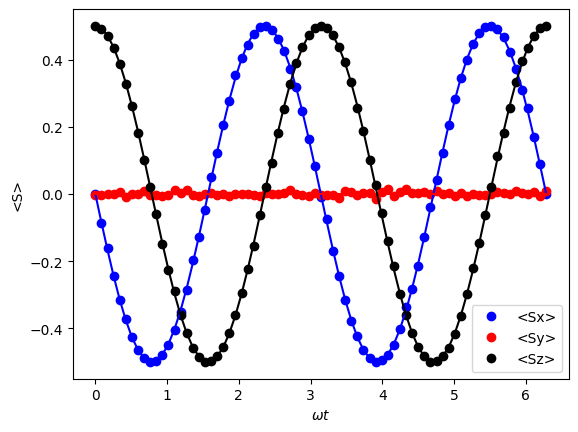

In [30]:
plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,-0.5*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0*tau_range,'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

Well, that looks pretty good! We could send this to actual quantum hardware. But there's actually a more efficient way to compute expectation values worth mentioning. There is something nice about getting down to the lowest level and reconstructing expectation values from counts. It really hammers home what an expectation value actually is and how little one learns from a single quantum experiment. But for the sake of efficiency, we can let Qiskit do some of the heavy lifting for us via the Estimator primitive.

To use this alternative method we need only a single circuit without the measurements (and associated rotations). That's pretty simple here.

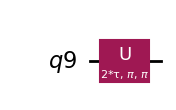

In [31]:
tau = Parameter('τ')

Nt = 75
qr = QuantumRegister(1)

timecirc2 = QuantumCircuit(qr) 

#no initial unitary transformation since |ψ(0)> = |+>

timecirc2.u(2*tau,np.pi,np.pi,qr) #apply exp(-iHt/ħ)

timecirc2.draw('mpl')

The next step is to define observables, which are just the spin operators. Qiskit has the Pauli operators available as built-in operators. The term "sparse" refers to the method of storage. An operator acting on an $N$-qubit state is represented by a $2^{N}\times 2^{N}$ matrix. The grows wildly fast with $N$. Fortunately, most entries (for many operators of physical interest) are zero. A "sparse" matrix object is on in which only the nonzero entries (and locations) are specified, and this technique allows one to construct representations of operators for much larger systems than if the (many) zeros are also stored.

Of course, for a single-qubit circuit, this is admittedly overkill. But there's value in learning the general methods for simple cases.

In [32]:
from qiskit.quantum_info import SparsePauliOp

Sx = SparsePauliOp.from_list([("X", 0.5)])
Sy = SparsePauliOp.from_list([("Y", 0.5)])
Sz = SparsePauliOp.from_list([("Z", 0.5)])

We then just run through essentially the same steps. Note, however, that now we bundle the circuit, the parameters, and the operators being measured into a single PUB. 

In [33]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

pub = (
    timecirc2,  # circuit
    [[Sx], [Sy], [Sz]],  # Observables
    tau_range,
)

job_result = estimator.run(pubs=[pub]).result()

The desired expectation values are stored in the order specified and can be peeled off the job result as follows.

In [34]:
sx_est = job_result[0].data.evs[0]
sy_est = job_result[0].data.evs[1]
sz_est = job_result[0].data.evs[2]

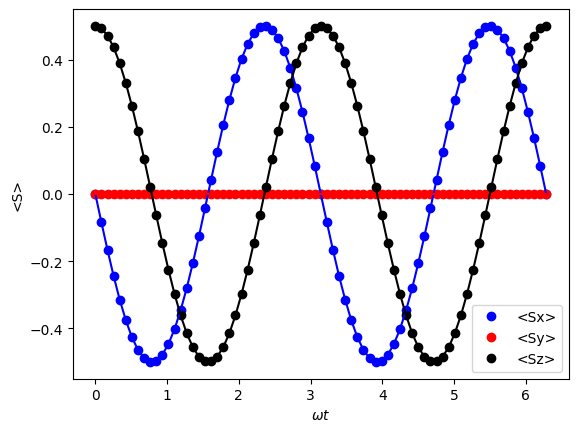

In [35]:
plt.plot(tau_range,sx_est,'bo',label='<Sx>')
plt.plot(tau_range,sy_est,'ro',label='<Sy>')
plt.plot(tau_range,sz_est,'ko',label='<Sz>')
plt.plot(tau_range,-0.5*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0*tau_range,'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

It's not even that this looks comparable to the last attempt. It looks <i>much</i> better (it's <i>less</i> noisy). The sampler result only contains statistical "noise" due finite sampling (number of shots), but even that has been reduced significantly as a tradeoff for ceding some of our low-level control of the experimental details. This much simpler version seems the better choice to send to an actual device.

But a word of caution. When using the simulator, the <i>exact</i> expectation values are computed for the specified operators. On a real device, some complicated techniques are employed to perform the actual calculation as carefully as possible. This <i>can</i> result in surprising long execution times of which the user seemingly has no control. With the open-access (free) plan giving users only ten minutes of quantum computation time, such uncontrolled execution times can quickly devour the monthly allotment of minutes, or even result in jobs that can't be finished. 

Note: as of the time of writing this, IBM's devices will cancel any jobs on the open-access plan that run for longer than ten minutes.

Reducing the number of time points is one way to minimize computation time. Additionally, one <i>can</i> trade accuracy for efficiency by specifying the maximum number of shots (see Qiskit documentation). When the maximum number of shots are unspecified, the execution time ends up being rather unconstrained, and the estimate provided (once a job is submitted) can be a significant underestimation. 

At this point, we can try these circuits using Estimator on a real device by making our operators and circuit ISA compliant and bundling them with the time parameters into a single PUB. Before using either method to access real hardware, you'll need to access your IBM account. Your IBM Quantum Token can be copied from your IBM Quantum Dashboard when you log in.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
#First time, use this:
service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
#overwrite = True

#After executing the above line, the token becomes linked to your device.
#Subsequent times (or in future notebooks) you can use this simpler command:
#service = QiskitRuntimeService()

## Estimator

In [ ]:
#this grabs the "least busy" device (i.e., shortest queue) and prints the name
#you'll need a specific device chosen for the ISA conversion (next step)
backend = service.least_busy(simulator=False, operational=True)
backend.name

The next step is to convert the circuit and operators to instructional set architecture (ISA), meaning that the job will be converted into a job involving only the rules that a particular device knows how to execute. You can think of this as "something you just have to do," as a deeep understanding of what's happening is not necessary to obtain results. 

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(timecirc2)

isa_Sx = Sx.apply_layout(layout=isa_circuit.layout)
isa_Sy = Sy.apply_layout(layout=isa_circuit.layout)
isa_Sz = Sz.apply_layout(layout=isa_circuit.layout)

<b>IMPORTANT WARNING: </b> When the author executed the following cell, the job ran for ten minutes before being canceled (allowed computation time exceeded). You might wish to look up how to specify the number of shots (and reduce the maximum!) or, more simply, reduce the number of time samples from 75 to something much modest (e.g., 15). But in principle, the following cell will run the Estimator circuit to compute expectation values for the spin component operators.

The circuit, observables, and the range of time samples are then bundled into a PUB and executed using ```Estimator```.

In [ ]:
pub = (
    isa_circuit,  # circuit
    [[isa_Sx], [isa_Sy], [isa_Sz]],         # Observables
    tau_range,  # parameters
)

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

estimator = Estimator(backend)
job = estimator.run(pubs=[pub])

result = job.result()

If you go to look at your current/past Jobs from the IBM Quantum Dashboard, you can find instructions for downloading the job result later (especially helpful if the queue time is long, and you end up interrupting the kernel and reopening the notebook later). If you wait until the job completes, you do not need the following step (but it doesn't hurt anything).

In [ ]:
job = service.job('<JOB-ID-HERE>')
job_result = job.result()

The remaining steps follow exactly the same form as when we used the simulator.

In [ ]:
sx_estq = job_result[0].data.evs[0]
sx_estq = job_result[0].data.evs[1]
sx_estq = job_result[0].data.evs[2]

In [ ]:
plt.plot(tau_range,sx_estq,'bo',label='<Sx>')
plt.plot(tau_range,sy_estq,'ro',label='<Sy>')
plt.plot(tau_range,sz_estq,'ko',label='<Sz>')
plt.plot(tau_range,sx_est,'k.',label='<Sx>')
plt.plot(tau_range,sy_est,'k.',label='<Sy>')
plt.plot(tau_range,sz_est,'k.',label='<Sz>')
plt.plot(tau_range,-0.5*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0*tau_range,'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

## Time evolution in arbitrary magnetic field

It's possible to compute the general case ${\bf B} = B_{0}\hat{\bf n}$. Instead of tackling that, let's just look closely at a particular example of a magnetic field with more than one component:

$${\bf B} = \frac{B_{0}}{\sqrt{2}}\hat{\bf x} + \frac{B_{0}}{\sqrt{2}}\hat{\bf y}$$

This corresponds to $\theta = \frac{\pi}{2}$, $\phi = \frac{\pi}{4}$, so

$$\exp\left[-i\hat{H}t/\hbar\right] = \hat{U}\left(\omega t, \frac{3\pi}{4}, -\frac{3\pi}{4}\right)$$

Analytically, we can write out the expected spin components as 

$$\left\langle \hat{S}^{x} \right\rangle = \frac{\hbar}{2}\cos\frac{3\pi}{4}\sin(\omega t)$$
$$\left\langle \hat{S}^{y} \right\rangle = \frac{\hbar}{2}\sin\frac{3\pi}{4}\sin(\omega t)$$
$$\left\langle \hat{S}^{z} \right\rangle = \frac{\hbar}{2}\cos(\omega t)$$

We employ the ```Sampler``` primitive and the simulator for the remainder of this notebook. To use ```Estimator``` or to execute on real hardware, one can apply the minimal modifications discussed above.

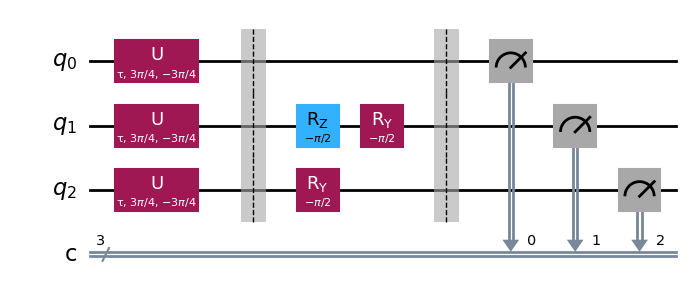

In [36]:
tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc = QuantumCircuit(qr,cr) 
θ = np.pi/2
ϕ = np.pi/4

timecirc.u(tau,np.pi/2+ϕ,-np.pi/2-ϕ,qr)
timecirc.barrier(qr)
timecirc.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc.rz(-np.pi/2,1) 
timecirc.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc.barrier(qr)
#no rotation needed to measure <Sz>

timecirc.measure(qr,cr)
timecirc.draw('mpl')

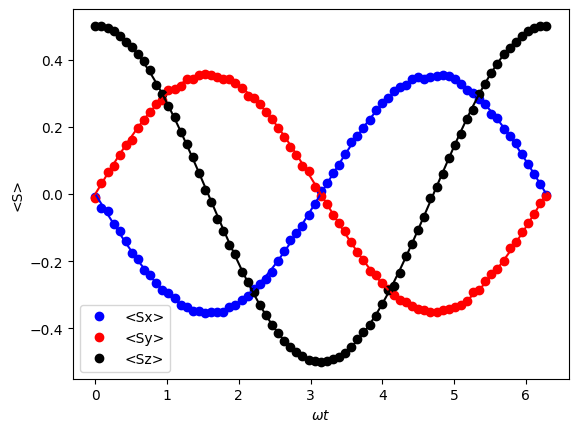

In [37]:
tau_range = np.linspace(0, 2*np.pi, Nt)

from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

Sx = np.zeros(Nt)
Sy = np.zeros(Nt)
Sz = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx[n] = Sx[n] + 0.5*simcounts[state]/nshots
        else:
            Sx[n] = Sx[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy[n] = Sy[n] + 0.5*simcounts[state]/nshots
        else:
            Sy[n] = Sy[n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Sz[n] = Sz[n] + 0.5*simcounts[state]/nshots
        else:
            Sz[n] = Sz[n] - 0.5*simcounts[state]/nshots


plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

### Introduction to Trotter steps

For short time steps, we <i>can</i> approximate the full operator by a sequence of noncommuting operators. Taking the full time evolution operator to be of the form $\hat{U} = \exp\left[it(\hat{A}+\hat{B})\right]$ for $\left[\hat{A},\hat{B}\right] \neq 0$. It is possible to show that

$$\exp\left[it\left(\hat{A}+\hat{B}\right)\right] = \lim_{n\rightarrow\infty}\left(\exp\left[i\frac{t}{n}\hat{A}\right]\left[i\frac{t}{n}\hat{B}\right]\right)^{n}$$

That is, we <i>should</i> be able to get increasingly accurate results by slicing up the time step into many substeps. The above expression is known as the <b>Lie-Trotter formula</b>, and the main idea is to compute (approximately) the time evolution of the quantum state at time $t$ by taking $n$ small steps of size $\frac{t}{n}$ using the product of simpler operator exponentials. For $n$ sufficiently large, the approximate result should converge to the exact result. This process is sometimes referred to as <b>Trotterization</b>.

Before diving in, it's worth asking <i>why</i> one would do this when the exact result is much simpler. The interactions of a single spin with an external magnetic field are special in that it is possible to obtain the exact time evolution operator. For multiple spins, the types of possible interactions <i>between</i> spins result in significantly more complicated Hamiltonians for which this exact analysis is not generally possible. But by decomposing (approximately) the exponential of a fairly complicated Hamiltonian into a series of simple Trotterized factors, it becomes possible to simulate much more interesting dynamics. Indeed, the anticipated value of future quantum devices is that such simulations will be much more efficient than state-of-the-art computations on classical devices.

Below is an example of the Trotterization scheme where the number of Trotter steps is set to ```ntrot```. 

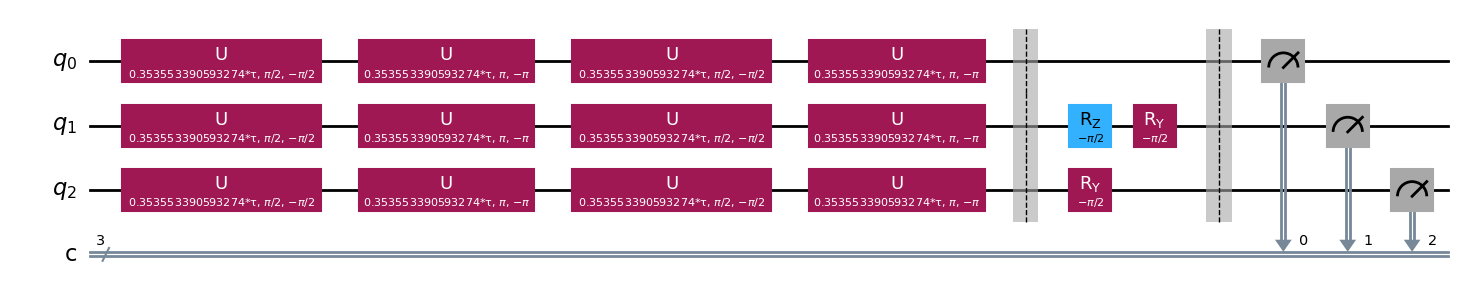

In [38]:
tau = Parameter('τ')
Nt = 75

tau_range = np.linspace(0, 2*np.pi, Nt)

qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc0 = QuantumCircuit(qr,cr) 

#vary this:
ntrot = 2

for i in range(0,ntrot):
    timecirc0.u(tau/(np.sqrt(2)*ntrot),np.pi/2,-np.pi/2,qr)
    timecirc0.u(tau/(np.sqrt(2)*ntrot),np.pi,-np.pi,qr)
    
timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1) 
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw('mpl')

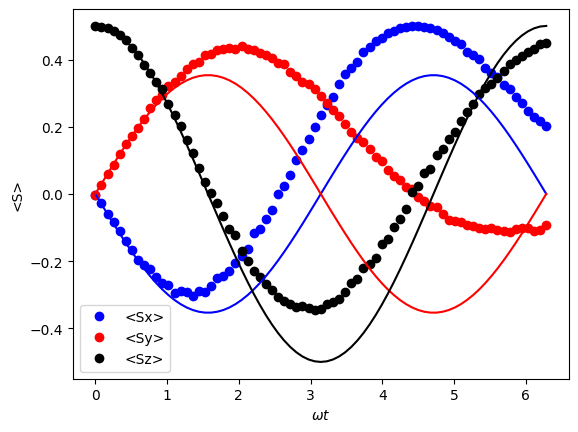

In [39]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc0, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

Sx = np.zeros(Nt)
Sy = np.zeros(Nt)
Sz = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx[n] = Sx[n] + 0.5*simcounts[state]/nshots
        else:
            Sx[n] = Sx[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy[n] = Sy[n] + 0.5*simcounts[state]/nshots
        else:
            Sy[n] = Sy[n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Sz[n] = Sz[n] + 0.5*simcounts[state]/nshots
        else:
            Sz[n] = Sz[n] - 0.5*simcounts[state]/nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

<b>Exercise: </b> Vary the number of Trotter steps to gain intuition for how many are required for the simulation to converge to the theoretical result.

<b>Exercise: </b> Try using this on quantum hardware. Increase the number of Trotter steps <i>slowly</i> from one. After observing the algorithm beginning to converge, you will eventually observe that noise begins to overwhelm the result. As circuit depth increases (with number of steps), the errors also increase. There is a very real tradeoff between increasing the steps to achieve convergence of the algorithm and limiting the number of steps to keep noise under control 

## Version information:

In [40]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.25.0'

In [41]:
import qiskit 

qiskit.version.get_version_info()

'1.1.1'